# Implementing and Exploring Auto-Regressive (AR) models

In this notebook, we will implement and train a Neural Autoregressive Density Estimator (NADE) model on the MNIST dataset, analyze its sampling behavior and training dynamics, and adapt the code to explore its differences from a simpler FVSBN model. 


## Part 1: Setup
### Import necessary libraries

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

import os
from datetime import datetime


### Load MNIST dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:36<00:00, 268130.47it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 72288.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1462714.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1012195.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
print(train_loader.dataset)
print(test_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## Part 2: Explore and visualize data
### Visualize samples

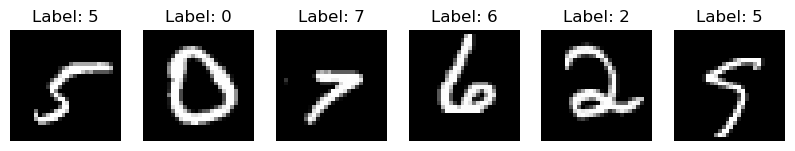

In [4]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')
plt.show()

### Selective subset training
For a faster training,we  only train on a subset of images from each digit (class)



In [5]:
samples_per_class = 1000
torch.manual_seed(123)

'''  Create train_subset as a subset of the original training set based on the given instruction   '''
targets = torch.tensor(train_dataset.targets)

subset_indices = []
for class_label in range(10):  # assuming 10 classes (digits 0-9)
    class_indices = torch.where(targets == class_label)[0]
    selected = class_indices[torch.randperm(len(class_indices))[:samples_per_class]]
    subset_indices.extend(selected.tolist())


train_subset = Subset(train_dataset, subset_indices)

'''  Update train_loader based on created train_subset   '''
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_38951/752742415.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(train_dataset.targets)


### Selective digit training
For even faster training practice, only focuse on a subset of digits that are easier to learn



In [6]:
train_loader

In [7]:
# Train only on digits 1 and 7 (easiest to learn)
digit_filter = [1, 7]

targets = torch.tensor(train_dataset.targets)

'''  Keep only digits in digit_filter in the training and test sets   '''
train_focused_indices = [i for i in subset_indices if targets[i].item() in digit_filter]
train_focused = Subset(train_dataset, train_focused_indices)

test_focused_indices = [i for i, t in enumerate(test_dataset.targets) if t in digit_filter]
test_focused = Subset(test_dataset, test_focused_indices)

'''  Update train_loader based on created train_subset   '''
training_focused_loader = DataLoader(train_focused, batch_size=128, shuffle=True)
test_focused_loader = DataLoader(test_focused, batch_size=128, shuffle=True)

/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_38951/3902780187.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(train_dataset.targets)


## Part 3: Implement AR



In [11]:
# 5. NADE Model
class NADE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512):
        """Initialize the Neural Autoregressive Density Estimation model.

        Args:
            input_dim (int): Dimension of input data (flattened image size)
            hidden_dim (int): Number of units in hidden layer
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.c = nn.Parameter(torch.zeros(hidden_dim))
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(input_dim))

        # Training metadata
        self.start_epoch = 0
        self.best_loss = float('inf')
        self.train_history = []
        self.test_history = []

    def forward(self, x):
        """Forward pass through the NADE model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            tuple: (x_hat, all_h) where:
                x_hat: reconstructed probabilities for each dimension
                all_h: all hidden states during autoregressive process
        """
        batch_size = x.size(0)
        x_hat = torch.zeros_like(x)
        all_h = []
        for d in range(self.input_dim):
            # Compute pre-activation for dimension d:
            # a_d = c + sum_{k<d} x_k * W_k
            a_d = self.c + torch.matmul(x[:, :d], self.W[:d, :])
            h_d = torch.sigmoid(a_d)
            # Compute output probability for dimension d:
            # p_d = sigmoid(b_d + V.T h_d)
            p_d = torch.sigmoid(self.b[d] + torch.matmul(h_d, self.V[:, d]))
            x_hat[:, d] = p_d
            all_h.append(h_d)
        return x_hat, torch.stack(all_h, dim=1)

    def log_prob(self, x):
        """Compute log probability of input samples under the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            torch.Tensor: Log probabilities for each sample (batch_size)
        """
        x_hat, _ = self.forward(x)
        # Compute Bernoulli log likelihood:
        # log p(x) = sum_d [x_d * log(p_d) + (1-x_d) * log(1-p_d)]  --- update this in order to avoid log of zero
        epsilon = 1e-5
        x_hat = torch.clamp(x_hat, min=epsilon, max=1 - epsilon)
        log_prob = x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat)

        # Sum over all dimensions (input_dim)
        return log_prob.sum(dim=1)


    def generate_samples(self, num_samples=10):
        """
        Generates new images via ancestral sampling
        Args:
            num_samples: How many images to generate
        Returns:
            Tensor of shape (num_samples, input_dim)
        """
        samples = torch.zeros(num_samples, 784).to(device)
        with torch.no_grad():
            for d in range(784):
                p_d = self.forward(samples)[0][:, d]
                samples[:, d] = torch.bernoulli(p_d)
        return samples.cpu()


In [12]:
# The code runs faster if you run on GPU. Select Runtime -> Change runtime type -> T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Part 4: Train the model



In [13]:
model = NADE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 300
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch, _ in training_focused_loader:
        batch = batch.view(-1, 784).to(device)
        optimizer.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(training_focused_loader)
    train_losses.append(avg_train_loss)

    # Validation: similar to training, except no optimization and backward steps
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch, _ in test_focused_loader:
            batch = batch.view(-1, 784).to(device)
            test_loss += -model.log_prob(batch).mean()
        avg_test_loss = test_loss / len(test_focused_loader)
        test_losses.append(avg_test_loss)


    # For each epoch, print: epoch number, training loss, and test loss
    print(f"{epoch}, training_loss = {avg_train_loss}, test_loss = {avg_test_loss}")


0, training_loss = 485.71885871887207, test_loss = 425.554931640625
1, training_loss = 383.07337188720703, test_loss = 338.60357666015625
2, training_loss = 309.8661308288574, test_loss = 278.9835205078125
3, training_loss = 260.9707727432251, test_loss = 240.4549102783203
4, training_loss = 229.6417474746704, test_loss = 215.87200927734375
5, training_loss = 209.73782539367676, test_loss = 199.85629272460938
6, training_loss = 196.65266609191895, test_loss = 189.1337432861328
7, training_loss = 187.6312131881714, test_loss = 181.46437072753906
8, training_loss = 181.12807369232178, test_loss = 175.9446258544922
9, training_loss = 176.06694793701172, test_loss = 171.69703674316406
10, training_loss = 172.50932788848877, test_loss = 168.33924865722656
11, training_loss = 169.72074127197266, test_loss = 165.66790771484375
12, training_loss = 167.1359167098999, test_loss = 163.49700927734375
13, training_loss = 165.27065086364746, test_loss = 161.60842895507812
14, training_loss = 163.283

# Part 5: Analyze Results



The model has clearly converged. As shown in the plot, The training and validation loss curves drop sharply at the beginning and then progressively level off as training continues which shows the convergence.
After 300 epochs, the training loss (72.61) and test loss (71.93) are very close.

another thing that we can see is that, the training and test loss remain very close to each other across all epochs, indicating no major overfitting and good generalization.

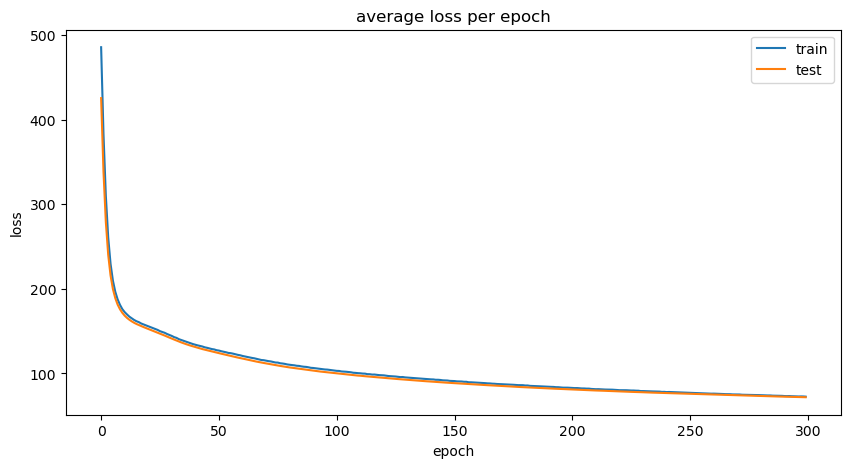

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("average loss per epoch")
plt.show()

# Part 6: Generate and visualize samples


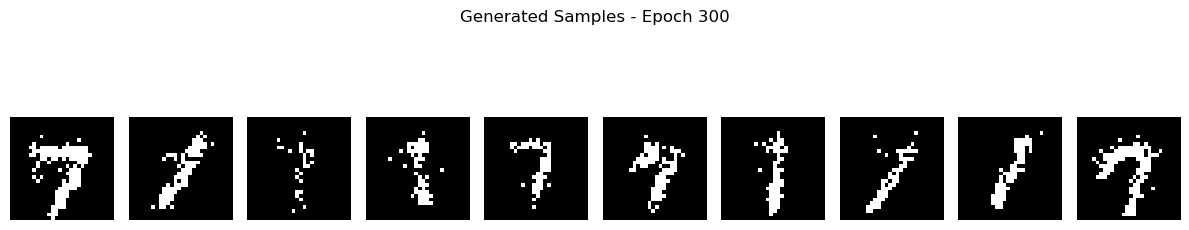

In [16]:
samples = model.generate_samples()
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(samples[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Generated Samples - Epoch {num_epochs}")
plt.tight_layout()
plt.show()

# Part 7: FVSBN Implementation
### TODO:

Compare and contrast the model structures of FVSBN and NADE by addressing:

  (a) How the conditional probability p(x_i|x_<i) is computed differently in each architecture

  * FVSBN: Each pixel is predicted using a masked linear transformation of previous pixels.
  * NADE: Here we use one layer neural network instead of logistic regression. Hidden units act like a “context encoder” for previously seen pixels.


  (b) The role of hidden units in NADE versus direct parameterization in FVSBN

  * FVSBN: Has no hidden layer. Each conditional distribution is a simple function of inputs before it. because of that its simpler and faster than NADE.
  * NADE: Hidden units have been used to modeling complexity. They help NADE approximate complex multimodal distributions because we add another layer and it makes our model more powerful.

  (c) The memory requirements for each model given an input dimension D. Support your analysis with specific equations from both architectures.

  * FVSBN: In each step parameters are  $\alpha_i = \{\alpha_0^i ,  \alpha_1^i, ... ,\alpha_{i - 1}^i\}$ so the conditional for variable xi requires i parameters,  and hence the total number of parameters is given by $\sum_{i=1}^{D} i = O(D^2)$.
  * NADE: The total number of parameters in this model is dominated by the matrices $\{ A_1, ... , A_n \}$ which their dimensions is $ D * (i - 1) $ now the total number of parameters is $\sum_{i=1}^{H} D(i - 1) = O(DH^2)$ we can shared parameters and tie weights to reduce the number of parameters to $O(HD)$ which H is the number of hidden nodes.

3. Empirical Evaluation
Design a systematic comparison between your trained FVSBN and NADE models by evaluating:

  (a) Training convergence rates using identical hyperparameters
    
  * FVSBN: Converges faster because has fewer parameters.
  * NADE: Takes longer to converge because it has a hidden layer with more parameters to tune. However, it may reach a better final performance due to its flexibility.

  (b) Sample quality through both visual inspection and quantitative metrics (e.g., log-likelihood on test set)

  * FVSBN: samples are but a little bit unrealistic because without a hidden layer FVSBN can't model the complex patterns like edges and loops (as we can see in the outputs we can't see 7 because of the little edge that it has and the top of images are blurry).
  * NADE: Hidden layers help capture complex relationships , so NADE perform much better here and its outputs are more coherent.

  the overall loss is higher in the FVSBN than NADE after 300 epochs.

  (c) Computational efficiency during both training and generation. What fundamental architectural characteristics explain the performance differences you observe?

  FVSBN is faster in the training phase because it uses just one forward pass with matrix multiplication but in contrast NADE  builds hidden layers per pixel, which adds up computationally.

  but both of them are slow in the sampling phase. because they must sample pixels one-by-one, because each pixel depends on the ones before it, and there is no way to parallelize this process.



In [27]:
class FVSBN(nn.Module):
    def __init__(self, input_dim=784):
        super().__init__()
        self.input_dim = input_dim

        self.W = nn.Parameter(torch.randn(input_dim, input_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(input_dim))
        self.register_buffer("mask", torch.tril(torch.ones(input_dim, input_dim), diagonal=-1))

        # Training metadata
        self.start_epoch = 0
        self.best_loss = float('inf')
        self.train_history = []
        self.test_history = []


    def forward(self, x):
        W_masked = self.W * self.mask 
        logits = x @ W_masked.T + self.b 
        probs = torch.sigmoid(logits)
        return probs

    def log_prob(self, x):
        x_hat = self.forward(x)
        # Compute Bernoulli log likelihood:
        # log p(x) = sum_d [x_d * log(p_d) + (1-x_d) * log(1-p_d)]  --- update this in order to avoid log of zero
        epsilon = 1e-6
        x_hat = torch.clamp(x_hat, min=epsilon, max=1 - epsilon)
        log_prob = x * torch.log(x_hat + epsilon) + (1 - x) * torch.log(1 - x_hat + epsilon)

        # Sum over all dimensions (input_dim)
        return log_prob.sum(dim=1)


    def generate_samples(self, num_samples=10):
        samples = torch.zeros(num_samples, 784).to(device)
        with torch.no_grad():
            for d in range(784):
                p_d = self.forward(samples)[:, d]
                samples[:, d] = torch.bernoulli(p_d)
        return samples.cpu()


In [28]:
# The code runs faster if you run on GPU. Select Runtime -> Change runtime type -> T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [29]:
model_fvsbn = FVSBN().to(device)
optimizer = optim.Adam(model_fvsbn.parameters(), lr=1e-4)

num_epochs = 300
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_fvsbn.train()
    train_loss = 0

    for batch, _ in training_focused_loader:
        batch = batch.view(-1, 784).to(device)
        optimizer.zero_grad()
        loss = -model_fvsbn.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(training_focused_loader)
    train_losses.append(avg_train_loss)

    # Validation: similar to training, except no optimization and backward steps
    model_fvsbn.eval()
    with torch.no_grad():
        test_loss = 0
        for batch, _ in test_focused_loader:
            batch = batch.view(-1, 784).to(device)
            test_loss += -model_fvsbn.log_prob(batch).mean()
        avg_test_loss = test_loss / len(test_focused_loader)
        test_losses.append(avg_test_loss)


    # For each epoch, print: epoch number, training loss, and test loss
    print(f"{epoch}, training_loss = {avg_train_loss}, test_loss = {avg_test_loss}")


0, training_loss = 535.3846206665039, test_loss = 525.8280029296875
1, training_loss = 517.7595252990723, test_loss = 508.8770751953125
2, training_loss = 501.4939842224121, test_loss = 493.24981689453125
3, training_loss = 486.417688369751, test_loss = 478.955810546875
4, training_loss = 472.77319717407227, test_loss = 465.7610168457031
5, training_loss = 460.11681747436523, test_loss = 453.6865539550781
6, training_loss = 448.412654876709, test_loss = 442.5688171386719
7, training_loss = 437.87515449523926, test_loss = 432.3356018066406
8, training_loss = 428.075138092041, test_loss = 422.81341552734375
9, training_loss = 418.9977626800537, test_loss = 414.0670166015625
10, training_loss = 410.5958824157715, test_loss = 405.9498291015625
11, training_loss = 402.7729034423828, test_loss = 398.35162353515625
12, training_loss = 395.5223026275635, test_loss = 391.2958984375
13, training_loss = 388.7089614868164, test_loss = 384.7149658203125
14, training_loss = 382.2833595275879, test_l

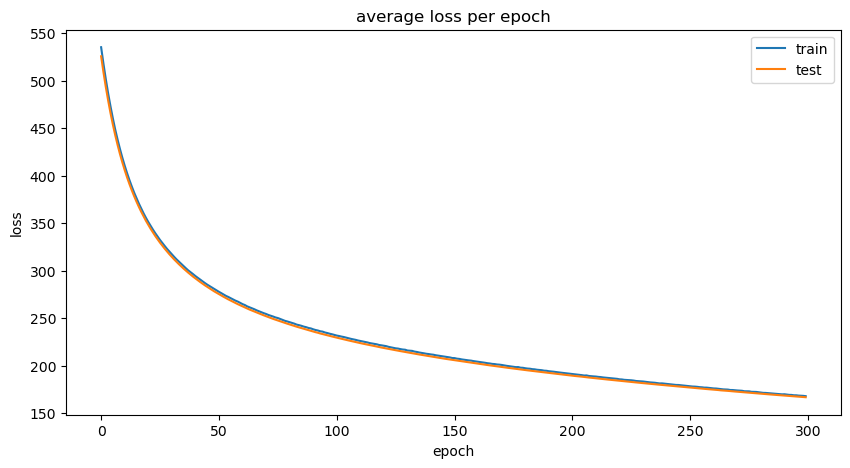

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("average loss per epoch")
plt.show()

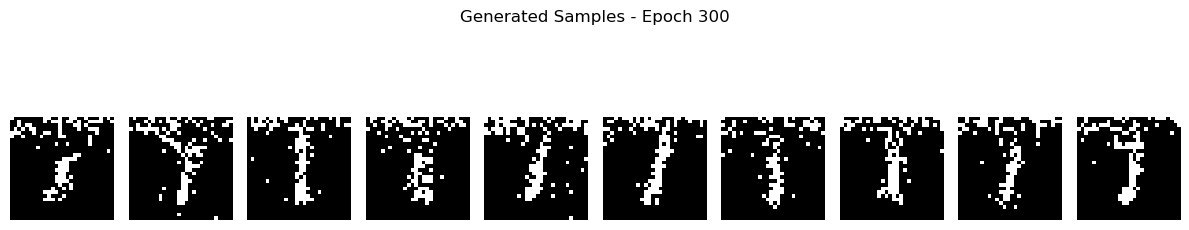

In [31]:
samples = model_fvsbn.generate_samples()
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(samples[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Generated Samples - Epoch {num_epochs}")
plt.tight_layout()
plt.show()